In [1]:
from create_percent_diff_summary import invert_dotson_fcn, invert_pig_fcn, invert_thwaites_fcn, compute_C_mean, compute_u_avg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as colorbar
import os
import sys
import firedrake
import copy
import pickle
import pandas as pd

2024-10-23 13:57:31.154625: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 13:57:31.155162: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 13:57:31.160885: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 13:57:31.204815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 13:57:31.983237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
select_dataset = 0

In [ ]:
# Get the evaluated objects and results for Dotson, PIG, and Thwaites
inv_dotson, theta_dotson, C_dotson = invert_dotson_fcn()

inv_pig, theta_pig, C_pig = invert_pig_fcn()

inv_thwaites, theta_thwaites, C_thwaites = invert_thwaites_fcn()

In [3]:
inv_dotson, theta_dotson, C_dotson = invert_dotson_fcn()

Reading local outline
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing 3d function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1
Initializing heat transport
Reading velocity from measures database
C0 is constant: 0.01
Using loss function without sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.212709e+08   6.286605e+03                  2.025274e+04   
  1     4.245683e+07   2.185766e+03   2.025274e+04   5.063186e+04   3         2         0         1         3         
  2     7.537494e+06   3.973020e+02   5.063186e+04   5.063186e+04   4         3         0         2         2         
  3     1.338595e+06   5.088845e+01   5.063186e+04   5.063186e+04   5         4         0         3         2         
  4     3.167263e+05   1.325799e+01   5.063186e+04   5.063186e+04   6         5         0      

In [4]:
u_optimized =  inv_dotson.simulation()
#inv_dotson.C = C_dotson
firedrake.assemble(inv_dotson.loss_functional_nosigma(u_optimized))

253.04310569367632

In [14]:
u_optimized =  inv_dotson.simulation()
inv_dotson.C = C_dotson
inv_dotson.θ = theta_dotson
firedrake.assemble(inv_dotson.loss_functional_nosigma(u_optimized))

ConvergenceError: Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT

In [15]:
inv_dotson.C0

Constant([0.01], 79)

In [7]:
def eval_models(select_dataset, invert_obj):
    # invert_obj.opts = {"dirichlet_ids": invert_obj.drichlet_ids,
    #                 "side_wall_ids": invert_obj.side_ids,
    #                "diagnostic_solver_type": "icepack",
    #             "diagnostic_solver_parameters": {
    #                 "max_iterations":50,},}
    # invert_obj.create_model_weertman()
    C_mean = compute_C_mean(select_dataset)
    compute_u_avg(invert_obj, C_mean)
    if select_dataset == 0:
        base_folder = 'mlp_ensemble_0' 
    elif select_dataset == 1:
        base_folder = 'mlp_ensemble_1'
    elif select_dataset == 2:
        base_folder = 'mlp_ensemble_2' 
    elif select_dataset == 3:
        base_folder = 'mlp_ensemble_3'
    elif select_dataset == 4:
        base_folder = 'mlp_ensemble_4'
    elif select_dataset == 5:
        base_folder = 'mlp_ensemble_5'
    summary_list = []
    class_list = []
    u_optimized_list = []
    loss_function_list = []

    error_list = []
    columns_list = []
    df_summary_list = []

    # Collect all temp objects for later plotting
    temp_objects = []

    for folder in os.listdir(base_folder):
        if not os.path.isdir(os.path.join(base_folder, folder)):
            continue  # Skip if not a directory
        
        try:
            # Skip folders that don't contain numeric names (if needed)
            folder_num = int(folder)
        except ValueError:
            continue
        
        print('Processing folder:', folder)
        path = os.path.join(base_folder, folder)
        files = [f for f in os.listdir(path) if f.endswith('.pkl')]
        
        if not files:
            print(f"No .pkl files found in folder {folder}. Skipping.")
            continue
        
        temp_object = copy.copy(invert_obj)
        columns = None
        r2_list, r2_adjusted_list, mse_list = [], [], []
        
        for file in files:
            try:
                with open(os.path.join(path, file), "rb") as f:
                    model_bundle = pickle.load(f)
                    r2_list.append(model_bundle['r2_test'])
                    r2_adjusted_list.append(model_bundle['r2_adjusted_test'])
                    mse_list.append(model_bundle['mse_test'])
                    columns = model_bundle.get('input_columns', columns)
            except Exception as e:
                print(f"Error processing file {file} in folder {folder}: {e}")
                continue
        if r2_list and r2_adjusted_list and mse_list:
            r2_stats = pd.DataFrame(r2_list).describe()
            r2_adjusted_stats = pd.DataFrame(r2_adjusted_list).describe()
            mse_stats = pd.DataFrame(mse_list).describe()
            
            summary_list.append({
                'input_columns': columns,
                'r2_mean': r2_stats.loc['mean'].values[0],
                'r2_std': r2_stats.loc['std'].values[0],
                'r2_median': r2_stats.loc['50%'].values[0],
                'r2_adjusted_mean': r2_adjusted_stats.loc['mean'].values[0],
                'r2_adjusted_std': r2_adjusted_stats.loc['std'].values[0],
                'r2_adjusted_median': r2_adjusted_stats.loc['50%'].values[0],
                'mse_mean': mse_stats.loc['mean'].values[0],
                'mse_std': mse_stats.loc['std'].values[0],
                'mse_median': mse_stats.loc['50%'].values[0]
            })
        

        model_name = files[0][:-8]  # Assumes model files end with a fixed pattern (e.g., '_model.pkl')
        print(model_name)
        print(columns)
        columns_list.append(columns)
        
        # Ensure the model_name is properly constructed
        model_file_path = os.path.join(base_folder, folder, model_name)
        temp_object.compute_C_ML_regress(
            filename=model_file_path, 
            half=False, 
            flip=False, 
            use_driving_stress=False, 
            C_bounds=[-50, 55], 
            θ_bounds=[-102, 200],
            folder = '', 
            number_of_models=10
        )
        
        u_optimized = temp_object.simulation()
        # Store or process `u_optimized` as needed
        u_optimized_list.append(u_optimized)
        loss_val = firedrake.assemble(temp_object.loss_functional_nosigma(u_optimized))
        loss_function_list.append(loss_val)
        temp_object.ML_u = u_optimized
        # Collect the temp object for plotting later
        temp_objects.append(temp_object)
    return temp_objects, summary_list, columns_list, u_optimized_list, loss_function_list

In [10]:
%%capture
temp_objects_dotson, summary_list_dotson, columns_list_dotson, u_optimized_list_dotson, loss_function_list_dotson = eval_models(select_dataset, inv_dotson)

ConvergenceError: Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT

In [62]:
%%capture
temp_objects_pig, summary_list_pig, columns_list_pig, u_optimized_list_pig, loss_function_list_pig = eval_models(select_dataset, inv_pig)


In [63]:
%%capture
temp_objects_thwaites, summary_list_thwaites, columns_list_thwaites, u_optimized_list_thwaites, loss_function_list_thwaites = eval_models(select_dataset, inv_thwaites)

In [64]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
import firedrake
def plot_percent_accounted(inverse_obj, vmin=None, vmax=None, axes=None):
    u_inv_norm = inverse_obj.get_magnitude(inverse_obj.inverse_u)
    u_default_norm = inverse_obj.get_magnitude(inverse_obj.default_u)
    u_ML_norm = inverse_obj.get_magnitude(inverse_obj.ML_u)
    ml_difference = firedrake.sqrt((u_inv_norm - u_ML_norm)**2)
    default_difference = firedrake.sqrt((u_inv_norm - u_default_norm)**2) 
    percent_difference = 100 * (default_difference - ml_difference) / default_difference
    percent_difference_fcn = firedrake.interpolate(percent_difference, inverse_obj.Q)

    # Plot on provided axes or create new if None
    if axes is None:
        fig, axes = inverse_obj.plot_bounded_antarctica()
    else:
        fig = None

    colors = firedrake.tripcolor(percent_difference_fcn, axes=axes, vmax=vmax, vmin=vmin)
    
    # Add colorbar only if no external axes were provided
    if fig is not None:
        fig.colorbar(colors)

    axes.set_title('Percent Difference Accounted for by ML')
    return fig, axes

In [16]:
compute_C_mean(select_dataset)

dataset selected: [df_dotson,df_dotson,df_thwaites]


1.039976493327037

/tmp/ipykernel_87985/3741505743.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


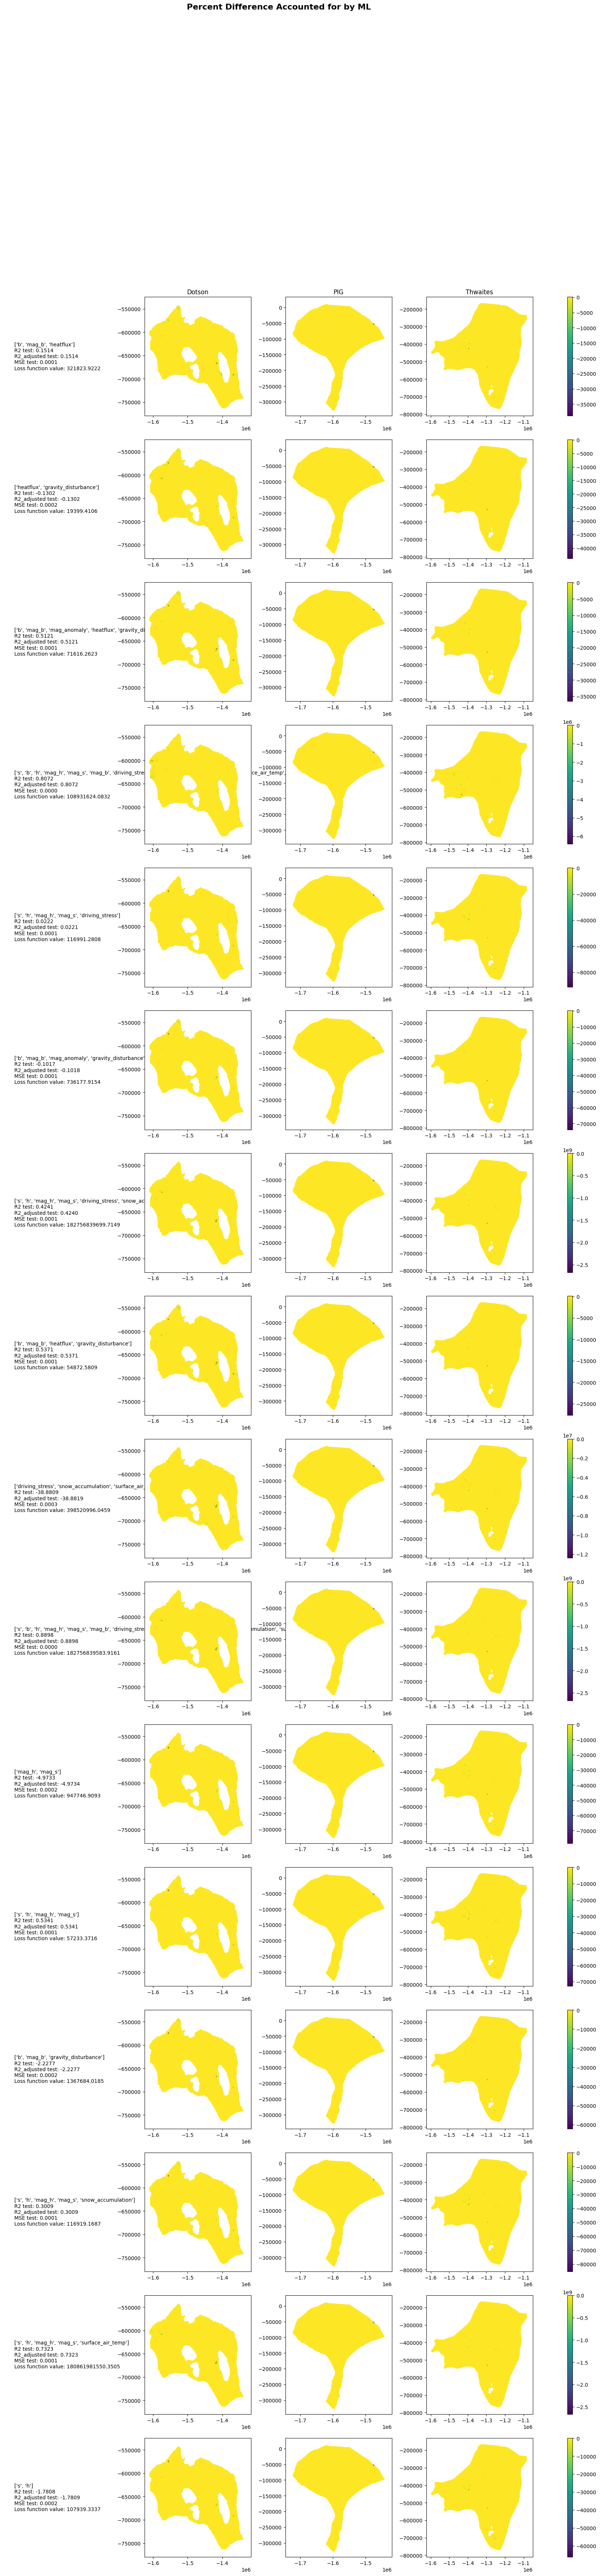

In [66]:
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as colorbar

# Since the lists have an equal number of objects, determine the number of rows
n_rows = len(temp_objects_dotson)

# Create a figure with 4 columns, where the last column is reserved for the color bar
fig = plt.figure(figsize=(20, 5 * n_rows))

# Set a supertitle for the entire figure
fig.suptitle("Percent Difference Accounted for by ML", fontsize=16, weight='bold')

# Use gridspec to specify a layout with 4 columns (including one for the color bar)
gs = gridspec.GridSpec(n_rows, 5, width_ratios=[4, 4, 4, 4, 0.2], wspace=0.4)

# Loop over the objects and plot in the corresponding grid positions
for row in range(n_rows):
    # Summary column (column 0)
    ax_summary = fig.add_subplot(gs[row, 0])
    summary_text = (
        f"{columns_list_dotson[row]}\n"
        f"R2 test: {summary_list_dotson[row]['r2_mean']:.4f}\n"
        f"R2_adjusted test: {summary_list_dotson[row]['r2_adjusted_mean']:.4f}\n"
        f"MSE test: {summary_list_dotson[row]['mse_mean']:.4f}\n"
        f"Loss function value: {loss_function_list_dotson[row]:.4f}"
    )
    ax_summary.text(0.1, 0.5, summary_text, fontsize=10, va="center", ha="left")
    ax_summary.axis('off')  # Turn off the axis for the text column
    
    # Dotson column (column 1)
    ax_dotson = fig.add_subplot(gs[row, 1])
    _, ax_dotson = plot_percent_accounted(temp_objects_dotson[row],  axes=ax_dotson)
    if row == 0:
        ax_dotson.set_title("Dotson")
    else:
        ax_dotson.set_title("")
    
    # PIG column (column 2)
    ax_pig = fig.add_subplot(gs[row, 2])
    _, ax_pig = plot_percent_accounted(temp_objects_pig[row],  axes=ax_pig)
    if row == 0:
        ax_pig.set_title("PIG")
    else:
        ax_pig.set_title("")
    
    # Thwaites column (column 3)
    ax_thwaites = fig.add_subplot(gs[row, 3])
    _, ax_thwaites = plot_percent_accounted(temp_objects_thwaites[row],  axes=ax_thwaites)
    if row == 0:
        ax_thwaites.set_title("Thwaites")
    else:
        ax_thwaites.set_title("")

    # Create a color bar at the end of the row (column 4)
    cax = fig.add_subplot(gs[row, 4])
    fig.colorbar(ax_dotson.collections[0], cax=cax)

# Adjust layout for better spacing
plt.tight_layout()


# Show the final figure
plt.show()
